## AIMonk Labs Assignment

In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input

In [2]:
LABELS_PATH = "labels.txt"
IMAGES_DIR = "images"

IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 8
LR = 1e-6

MODEL_SAVE_PATH = "aimonk_multilabel_resnet50.h5"

ATTR_NAMES = ["Attr1", "Attr2", "Attr3", "Attr4"]

In [3]:
df = pd.read_csv(
    LABELS_PATH,
    sep=r"\s+",
    header=None,
    keep_default_na=False
)
df.columns = ["image_name", "attr1", "attr2", "attr3", "attr4"]
df.head()


,image_name,attr1,attr2,attr3,attr4
0,image_0.jpg,1,NA,0,1
1,image_1.jpg,NA,0,0,0
2,image_2.jpg,1,1,0,0
3,image_3.jpg,1,1,0,0
4,image_4.jpg,1,1,0,0


In [4]:
def build_labels_and_masks(df):
    y = []
    mask = []

    for _, row in df.iterrows():
        row_y = []
        row_m = []

        for i in range(1, 5):
            val = row[f"attr{i}"]

            # handle both string "NA" and real np.nan
            if pd.isna(val) or str(val).upper() == "NA":
                row_y.append(0.0)
                row_m.append(0.0)
            else:
                row_y.append(float(val))
                row_m.append(1.0)

        y.append(row_y)
        mask.append(row_m)

    y = np.array(y, dtype=np.float32)
    mask = np.array(mask, dtype=np.float32)

    # final safety cleanup
    y = np.nan_to_num(y, nan=0.0)
    mask = np.nan_to_num(mask, nan=0.0)

    return y, mask

In [ ]:
def filter_missing_images(df, images_dir):
    df = df.copy()

    df["exists"] = df["image_name"].apply(lambda x: os.path.exists(os.path.join(images_dir, x)))
    missing = df[df["exists"] == False]["image_name"].tolist()

    df = df[df["exists"] == True].drop(columns=["exists"]).reset_index(drop=True)

    print("Total rows in labels.txt:", len(missing) + len(df))
    print("Images found:", len(df))
    print("Missing images:", len(missing))

    if len(missing) > 0:
        print("\nMissing images:")
        for x in missing[:20]:
            print(x)

    return df

df = filter_missing_images(df, IMAGES_DIR)

Total rows in labels.txt: 975
Images found: 972
Missing images: 3

First missing images:
image_489.jpg
image_624.jpg
image_875.jpg


In [6]:
y, mask = build_labels_and_masks(df)

In [7]:
from sklearn.model_selection import train_test_split

train_df, val_df, y_train, y_val, mask_train, mask_val = train_test_split(
    df, y, mask,
    test_size=0.15,
    random_state=42,
    shuffle=True
)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

print("Train size:", len(train_df))
print("Val size:", len(val_df))

Train size: 826
Val size: 146


In [8]:
def load_image(img_path):
    img = Image.open(img_path).convert("RGB")
    img = img.resize((IMG_SIZE, IMG_SIZE))
    img = np.array(img, dtype=np.float32)
    return img

def make_dataset(df, y, mask, training=True):
    images = []
    labels = []
    masks = []

    for i in range(len(df)):
        img_path = os.path.join(IMAGES_DIR, df.loc[i, "image_name"])
        img = load_image(img_path)

        images.append(img)
        labels.append(y[i])
        masks.append(mask[i])

    images = np.array(images, dtype=np.float32)
    labels = np.array(labels, dtype=np.float32)
    masks = np.array(masks, dtype=np.float32)

    # Preprocess for ResNet
    images = preprocess_input(images)
    print("Images min/max:", images.min(), images.max())

    ds = tf.data.Dataset.from_tensor_slices((images, labels, masks))

    if training:
        ds = ds.shuffle(512)

    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_dataset(train_df, y_train, mask_train, training=True)
val_ds = make_dataset(val_df, y_val, mask_val, training=False)

Images min/max: -123.68 151.061
Images min/max: -123.68 151.061


In [9]:
def compute_pos_weight(y, mask, max_clip=10.0):
    known = mask == 1

    pos = ((y == 1) & known).sum(axis=0).astype(np.float32)
    neg = ((y == 0) & known).sum(axis=0).astype(np.float32)

    pos_weight = []

    for p, n in zip(pos, neg):
        if p == 0:
            # if no positive samples, avoid weighting
            pos_weight.append(1.0)
        else:
            w = n / p
            w = min(w, max_clip)
            pos_weight.append(w)

    return np.array(pos_weight, dtype=np.float32)

In [10]:
def masked_weighted_bce(pos_weight):
    pos_weight = tf.constant(pos_weight, dtype=tf.float32)

    def loss_fn(y_true, logits, mask):

        # sigmoid cross entropy per element
        loss = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=y_true,
            logits=logits
        )  # shape: [batch, 4]

        # apply positive class weighting
        weight_matrix = y_true * pos_weight + (1 - y_true)
        loss = loss * weight_matrix

        # apply mask
        loss = loss * mask

        denom = tf.maximum(tf.reduce_sum(mask), 1.0)
        return tf.reduce_sum(loss) / denom

    return loss_fn

In [11]:
base_model = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base_model.trainable = False

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# IMPORTANT FIX: training=False
x = base_model(inputs)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(4)(x)

model = models.Model(inputs, outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         8,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,595,908 (90.01 MB)

 Trainable params: 8,196 (32.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [12]:
pos_weight = compute_pos_weight(y_train, mask_train)
print("pos_weight:", pos_weight)

pos_weight: [ 0.13383459  0.23519737  0.89873415 10.        ]


In [14]:
for batch in train_ds.take(1):
    images, labels, masks = batch
    print("Image min:", tf.reduce_min(images))
    print("Image max:", tf.reduce_max(images))

Image min: tf.Tensor(-123.68, shape=(), dtype=float32)
Image max: tf.Tensor(151.061, shape=(), dtype=float32)


In [16]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=LR,
    clipnorm=1.0
)
loss_function = masked_weighted_bce(pos_weight)

train_losses = []
iteration_numbers = []

@tf.function
def train_step(images, labels, masks):
    with tf.GradientTape() as tape:
        logits = model(images, training=True)

        tf.debugging.check_numerics(logits, "Logits contain NaN")

        loss = loss_function(labels, logits, masks)

        tf.debugging.check_numerics(loss, "Loss contains NaN")

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss


for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")

    it = 0
    for batch in train_ds:
        images, labels, masks = batch
        loss = train_step(images, labels, masks)

        train_losses.append(float(loss.numpy()))
        iteration_numbers.append(len(train_losses) - 1)

        if it % 20 == 0:
            print(f"Iteration {it}, Loss = {loss.numpy():.4f}")

        it += 1


Epoch 1/8
Iteration 0, Loss = 0.4215
Iteration 20, Loss = 0.8054
Iteration 40, Loss = 0.6953

Epoch 2/8
Iteration 0, Loss = 0.9089
Iteration 20, Loss = 0.7550
Iteration 40, Loss = 0.3719

Epoch 3/8
Iteration 0, Loss = 1.4893
Iteration 20, Loss = 0.4147
Iteration 40, Loss = 0.7826

Epoch 4/8
Iteration 0, Loss = 0.3579
Iteration 20, Loss = 0.4361
Iteration 40, Loss = 0.3693

Epoch 5/8
Iteration 0, Loss = 1.1936
Iteration 20, Loss = 0.8320
Iteration 40, Loss = 0.8146

Epoch 6/8
Iteration 0, Loss = 0.3879
Iteration 20, Loss = 0.4487
Iteration 40, Loss = 0.8720

Epoch 7/8
Iteration 0, Loss = 1.4180
Iteration 20, Loss = 0.8979
Iteration 40, Loss = 0.4284

Epoch 8/8
Iteration 0, Loss = 0.3365
Iteration 20, Loss = 0.6167
Iteration 40, Loss = 1.3354


In [17]:
model.save(MODEL_SAVE_PATH)
print("Saved model:", MODEL_SAVE_PATH)

Saved model: aimonk_multilabel_resnet50.h5


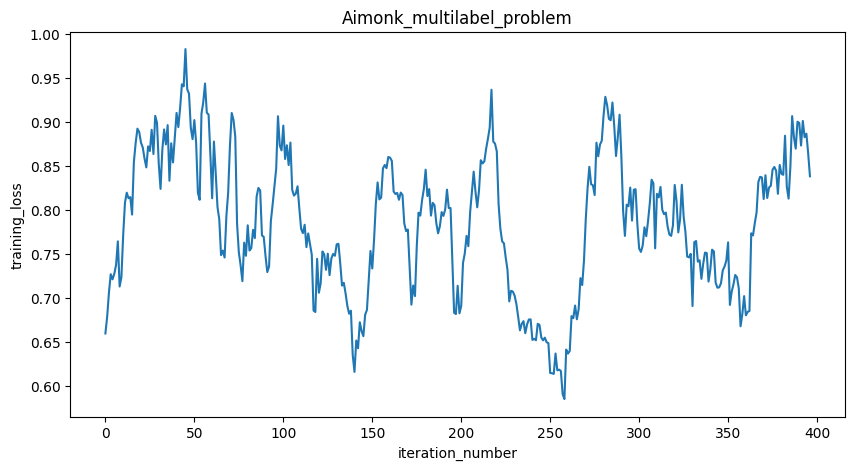

In [22]:
plt.figure(figsize=(10, 5))
window = 20
smoothed = np.convolve(train_losses, np.ones(window)/window, mode='valid')

plt.plot(smoothed)

plt.xlabel("iteration_number")
plt.ylabel("training_loss")
plt.title("Aimonk_multilabel_problem")

plt.show()


In [29]:
def predict_image(model, image_path, threshold=0.5):
    img = Image.open(image_path).convert("RGB")
    img = img.resize((IMG_SIZE, IMG_SIZE))
    img = np.array(img, dtype=np.float32)

    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)

    logits = model(img, training=False).numpy()[0]
    probs = tf.sigmoid(logits).numpy()

    present = []
    for i, p in enumerate(probs):
        if p >= threshold:
            present.append(ATTR_NAMES[i])

    return probs, present


# Example
sample_path = os.path.join(IMAGES_DIR, df.loc[735, "image_name"])
probs, present = predict_image(model, sample_path)

print("Image:", sample_path)
print("Probabilities:", probs)
print("Attributes present:", present)

Image: images\image_737.jpg
Probabilities: [0.09707567 0.7621913  0.56144255 0.119494  ]
Attributes present: ['Attr2', 'Attr3']


### Additional improvements

Additional improvements such as advanced augmentation strategies, fine-tuning deeper layers, focal loss for imbalance, threshold tuning, learning rate scheduling, and cross-validation were not implemented but could potentially improve performance further.